# Problem Statement
The objective of this analysis is to:

Identify customer types and distribution channels with the highest booking cancellation rates, and explore the contributing factors in order to recommend effective marketing strategies that aim to reduce the cancellation rate by 10% within the next 6 months.

## SMART Framework
    Specific: Analyze historical booking data to determine the key factors that influence booking cancellations using statistical, inferential, and visualization methods.

    Measurable: Focus on customer segments and distribution channels where the cancellation rate exceeds 20%, with the goal of reducing these rates to 10% or lower.

    Achievable: Use existing data from 2015–2017 to design targeted strategies for mitigating cancellations.

    Relevant: Understanding which customers and booking channels are most prone to cancellations is crucial for building a sustainable marketing approach.

    Time-bound: The research, analysis, and implementation of the recommendations are expected to be completed and produce measurable impact within six months.

## Key Analytical Questions (5W + 1H)
    What is the difference in booking cancellation rates between City Hotels and Resort Hotels?

    Why do guests cancel their bookings?

    Who are the customer segments with the highest cancellation rates?

    Where do cancellations occur most frequently—within a specific hotel type or channel?

    How have cancellation trends evolved from 2015 to 2017?

    How much does guest loyalty (i.e., repeated bookings) correlate with cancellation behavior?

## Stakeholders
Primary Stakeholders: ASD Group’s Sales and Marketing Team, who will use the insights and recommendations to tailor customer communication, promotional offers, and booking policies to reduce cancellations.

# Import Libraries

In this section, I’m importing the libraries required to process the dataset, perform statistical analysis, and visualize the results. Some of the key libraries include Pandas for data manipulation, Matplotlib/Seaborn for plotting, and Scipy for statistic thing.

In [1]:
# import libraries needed

import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Data Loading

In this section, I'm loading the Hotel Booking Demand dataset (CSV format) that I previously downloaded from Kaggle.

In [2]:
# reading csv

df = pd.read_csv("hotel_bookings.csv")
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


# Data Exploratory

In this section, I will explore the dataset to understand its structure and contents. This includes checking the columns and their meanings, getting general info about the data, identifying any missing values, and so on.

## Columns Checking

This section will be checking the columns and explain their meanings.

In [3]:
# show all columns in df
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

As we can see from output, there are the names of 32 columns in this dataset. I will provide a brief explanation of each column in the dataset to help understand their meaning.

- 'hotel': Type of hotel.
- 'is_canceled': Indicates if the booking was canceled or not. 1 for canceled and 0 for completed (checked-out) reservations.
- 'lead_time': The time period between the reservation made and the guest's check-in.
- 'arrival_date_year': The year of the guest's arrival.
- 'arrival_date_month': The month of the guest's arrival.
- 'arrival_date_week_number': The week number of the guest's arrival (calculated within the year).
- 'arrival_date_day_of_month': The day of the month the guest arrives.
- 'stays_in_weekend_nights': The number of nights the guest stays over the weekend.
- 'stays_in_week_nights': The number of nights the guest stays during the weekday.
- 'adults': The number of adult guests staying.
- 'children': The number of children guests staying.
- 'babies': The number of baby guests staying.
- 'meal': The type of meal plan selected for the stay: BB (Bed and Breakfast), HB (Half Board), FB (Full Board), or SC (Self-catering).
- 'country': The country of origin for the guest. There are 187 different countries.
- 'market_segment': The hotel’s method for categorizing guests into groups such as Direct, Corporate, Online TA, Offline TA/TO, Complementary, Groups, Undefined, or Aviation.
- 'distribution_channel': The method/platform used by the hotel to sell rooms: Direct, Corporate, TA/TO, Undefined, or GDS.
- 'is_repeated_guest': A boolean value indicating whether the guest has stayed before. 1 for returning guests, 0 for first-time guests.
- 'previous_cancellations': The number of bookings previously canceled by the guest. This value ranges from 0 to 26.
- 'previous_bookings_not_canceled': The number of bookings previously not canceled by the guest. This value ranges from 0 to 72.
- 'reserved_room_type': The room type reserved by the guest.
- 'assigned_room_type': The room type assigned to the guest upon check-in.
- 'booking_changes': The number of times the guest modified their booking. This value ranges from 0 to 21.
- 'deposit_type': The type of deposit paid by the guest: No Deposit, Refundable, or Non-Refundable.
- 'agent': The agent code (if the booking was made through an agent).
- 'company': The company code (if the booking was made through a company).
- 'days_in_waiting_list': The number of days a guest was on the waiting list before being assigned a room. The maximum value is 330 days.
- 'customer_type': The type of customer: Transient, Contract, Transient-Party, or Group.
- 'adr': Average Daily Rate — a key metric used in the hospitality industry to calculate average revenue earned per room sold (room revenue/rooms sold).
- 'required_car_parking_spaces': The number of parking spaces required by the guest.
- 'total_of_special_requests': The total number of special requests made by the guest (such as room preferences, etc.).
- 'reservation_status': The current status of the reservation: "Check-out" (the guest arrived and checked out as planned), "Canceled" (the reservation was canceled), or "No Show" (the guest didn't show up without canceling).
- 'reservation_status_date': The date the reservation status was last updated.

## General Information

This section will provide general information of dataset.

In [4]:
# df summary 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

As seen in the dataset, the columns have various data types such as str, int, and float. The dataset contains 119,390 records, but some columns have missing data (which we can flag as missing values). To understand how much data is missing, I will check for missing values in the dataset.

# Checking Missing Values

This section will provide any information about missing value.

In [5]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

As seen above, missing values are distributed in 4 columns: 4 missing values in 'children', 488 in 'country', 16,340 in 'agent', and 112,593 (most of them) in 'company'.

In [6]:
# checking missing values
df.isnull().sum().sum()

np.int64(129425)

Or we can see it in total: there are 129,425 missing values.

# Unique Value

This section will provide some informations about unique value from str columns.

In [7]:
# list unique value
for column in df:
    if df[column].dtypes == 'object':
        print(df[column].unique())

['Resort Hotel' 'City Hotel']
['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']
['BB' 'FB' 'HB' 'SC' 'Undefined']
['PRT' 'GBR' 'USA' 'ESP' 'IRL' 'FRA' nan 'ROU' 'NOR' 'OMN' 'ARG' 'POL'
 'DEU' 'BEL' 'CHE' 'CN' 'GRC' 'ITA' 'NLD' 'DNK' 'RUS' 'SWE' 'AUS' 'EST'
 'CZE' 'BRA' 'FIN' 'MOZ' 'BWA' 'LUX' 'SVN' 'ALB' 'IND' 'CHN' 'MEX' 'MAR'
 'UKR' 'SMR' 'LVA' 'PRI' 'SRB' 'CHL' 'AUT' 'BLR' 'LTU' 'TUR' 'ZAF' 'AGO'
 'ISR' 'CYM' 'ZMB' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN' 'ARE' 'TUN' 'JAM'
 'HRV' 'HKG' 'IRN' 'GEO' 'AND' 'GIB' 'URY' 'JEY' 'CAF' 'CYP' 'COL' 'GGY'
 'KWT' 'NGA' 'MDV' 'VEN' 'SVK' 'FJI' 'KAZ' 'PAK' 'IDN' 'LBN' 'PHL' 'SEN'
 'SYC' 'AZE' 'BHR' 'NZL' 'THA' 'DOM' 'MKD' 'MYS' 'ARM' 'JPN' 'LKA' 'CUB'
 'CMR' 'BIH' 'MUS' 'COM' 'SUR' 'UGA' 'BGR' 'CIV' 'JOR' 'SYR' 'SGP' 'BDI'
 'SAU' 'VNM' 'PLW' 'QAT' 'EGY' 'PER' 'MLT' 'MWI' 'ECU' 'MDG' 'ISL' 'UZB'
 'NPL' 'BHS' 'MAC' 'TGO' 'TWN' 'DJI' 'STP' 'KNA' 'ETH' 'IRQ' 'HND' 'RWA'
 'KHM' 'MCO' 'BGD' 'IMN

# Data Cleaning

In this section, I'm preparing the dataset to get it ready for analysis: filtering the data based on the problem I want to solve.

## Filtering Columns

Since the objective is determined,  it’s important to select the relevant columns for analyzing the cancellation rate based on customer segments and distribution channels. The reasons for selecting these columns are:

- 'hotel': to distinguish between the types of hotels

- 'is_canceled': the main topic of this analysis

- 'customer_type': to observe the cancellation rate for each customer type

- 'distribution_channel': to observe the cancellation rate for each distribution channel

- 'is_repeated_guest': to assess guest loyalty

- 'lead_time': to explore the relationship between cancellation rate and lead time

- 'booking_changes': to see whether guests who make more changes to their bookings are more likely to cancel

- 'previous_cancellations': to evaluate guests’ past cancellation history as a potential behavior indicator

- 'previous_bookings_not_canceled': to understand whether positive past experiences reduce the likelihood of cancellation

- 'adr' (Average Daily Rate): to check if room price influences booking cancellation decisions

- 'arrival_date_year', 'arrival_date_month', and 'arrival_date_day_of_month': to identify possible seasonal or yearly trends in cancellations

In [8]:
# Pemilihan kolom

main_df = df[[
    'hotel',                      # hotel type
    'is_canceled',                # main topic
    'customer_type',              # customer type
    'distribution_channel',       # distribution channel
    'is_repeated_guest',          # is the guest loyal or not
    'lead_time',                  # time range between booking and check-in
    'booking_changes',            # the count of booking changes
    'previous_cancellations',     # past cancellation history
    'previous_bookings_not_canceled',  # positive past experience
    'adr',                        # average daily rate
    'arrival_date_year',          # year of arrival
    'arrival_date_month',         # month of arrival
    'arrival_date_day_of_month'    # day of arrival
]]


## Columns Handling

This section is about handling problem(s) in columns selected. Note that in this project, outlier(s) and type of distribution(skewed/normal) are ignored.

### Drop Error Value

In the adr and is_canceled columns, there are some erroneous data. If is_canceled equals 0, it means the booking was not canceled and the guest checked out. This also means there should be a value in the adr column, as a completed stay should result in a payment. However, in the main dataset, there are some rows where is_canceled is 0 but the adr value is also 0. Based on this, I considered these records to be errors and decided to drop them.

In [9]:
# drop row which has 0 value, both in is_canceled and adr

main_df = main_df[~((main_df['adr'] <= 0) & (main_df['is_canceled'] == 0))].reset_index(drop=True)

### New Column Creation

To identify the guest's arrival date, we currently need to refer to three separate columns: arrival_date_year, arrival_date_month, and arrival_date_day_of_month. To simplify the analysis and visualization process, I combined them into a single new column called arrival_date. This new column was created using the map function.

In [10]:
# combine 3 separates columns (y, m, and d) to one new column
# 1. change month representation: char to number(in string)
month_map = {
    "January": "01",
    "February": "02",
    "March": "03",
    "April": "04",
    "May": "05",
    "June": "06",
    "July": "07",
    "August": "08",
    "September": "09",
    "October": "10",
    "November": "11",
    "December":"12"}

main_df['arrival_date_month_num'] = main_df['arrival_date_month'].map(month_map)

# 2. make a new column
main_df['arrival_date'] = pd.to_datetime(
                            main_df['arrival_date_year'].astype(str) + '-' +
                            main_df['arrival_date_month_num'] + '-' +
                            main_df['arrival_date_day_of_month'].astype(str),
                            format='%Y-%m-%d')


### Save Document

Since I will be creating a dashboard in Tableau, I will save the cleaned dataset as a CSV file.

In [11]:
# save to csv

main_df.to_csv("C:/Users/NEILA/analysis-of-cancellation-rate/main_df.csv", index=False)

# Exploration and Analysis

In this section, the analyst performs descriptive and inferential statistical analysis and prepares visualizations to answer the questions from the problem statement. As a guidance, I will use 6 analytical questions above.

## What is the difference in booking cancellation rates between City Hotels and Resort Hotels?

To answer this question, I use some measurement such as count and mean.

In [12]:
# Distribusi data booking dan cancel

print("Total booking\n", main_df.groupby('hotel')['arrival_date'].count(),"\n")
print("\nCancellation Rate Comparison\n", main_df.groupby('hotel')['is_canceled'].mean())

Total booking
 hotel
City Hotel      78251
Resort Hotel    39392
Name: arrival_date, dtype: int64 


Cancellation Rate Comparison
 hotel
City Hotel      0.423023
Resort Hotel    0.282342
Name: is_canceled, dtype: float64


As seen above, the total number of hotel bookings **differs** between the two hotel types, City Hotel has more bookings than Resort Hotel. However, the cancellation rate follows the same pattern, with City Hotel also having a higher cancellation rate. But to make it clearer, I will do a hypothesis test for this.

### Hypothesis Test

Since I’ve found that the average cancellation rate is higher in City Hotels than in Resort Hotels, I will conduct a two-sided hypothesis test to statistically examine the difference.

*Hypothesis Test – Comparing the Average Cancellation Rates Between Hotel Types*

Null Hypothesis (H₀): The average cancellation rate in City Hotels is less than or equal to the average cancellation rate in Resort Hotels.

Alternative Hypothesis (H₁): The average cancellation rate in City Hotels is greater than the average cancellation rate in Resort Hotels.

In [13]:
# Uji hipotesis

sample_city = main_df[main_df['hotel']=='City Hotel']['is_canceled']
sample_resort = main_df[main_df['hotel']=='Resort Hotel']['is_canceled']

t_stat,p_val = stats.ttest_ind(sample_city, sample_resort)
print('P-value:', p_val/2) #p-val dibagi dua karena outputnya adalah two-sided p-value
print('t-statistics:',t_stat)

P-value: 0.0
t-statistics: 47.46261713471404


Summary of Hypothesis Test:

The p-value from the hypothesis test is less than 0.05, which means there is enough evidence to reject the null hypothesis. Therefore, we can conclude that the average cancellation rate in City Hotels is significantly higher than in Resort Hotels.

## Why do guests cancel their bookings?

Since the distribution shape is not considered in this project, I will proceed with a correlation test under the assumption that all variables are normally distributed and contain no outliers.

**Correlation Analysis** → to examine the relationship between the cancellation rate and other variables

H0: There is no correlation between the cancellation rate and variable X

H1: There is a correlation between the cancellation rate and variable X

In this correlation analysis, I will explore the relationship between the `is_canceled` variable and the following variables:
`lead_time, is_repeated_guest, booking_changes, previous_cancellations, previous_bookings_not_canceled, adr, and arrival_date.`

In [14]:
# define variables for two types of hotels

city_hotel = main_df[main_df['hotel']=='City Hotel']
resort_hotel = main_df[main_df['hotel']=='Resort Hotel']

### Lead Time and Cancellation Rate

In [15]:
# 1. korelasi lead time dengan cancel rate -- hasilnya H0 ditolak
r_city, p_val_city = stats.spearmanr(city_hotel['lead_time'], city_hotel['is_canceled'])
r_resort, p_val_resort = stats.spearmanr(resort_hotel['lead_time'], resort_hotel['is_canceled'])

print("Result of correlation test between lead time and cancel rate in city hotel")
print("Spearman correlation:", r_city)
print("P-value:", p_val_city)

print("\nResult of correlation test between lead time and cancel rate in resort hotel")
print("Spearman correlation:", r_resort)
print("P-value:", p_val_resort)

Result of correlation test between lead time and cancel rate in city hotel
Spearman correlation: 0.31753533561135844
P-value: 0.0

Result of correlation test between lead time and cancel rate in resort hotel
Spearman correlation: 0.2743399434592529
P-value: 0.0


In the correlation test between lead_time and is_canceled, the p-value is less than 0.05 (a significant value), which provides enough evidence to reject H0 (there is a correlation). This indicates a relationship between cancel rate and the lead time variable across both types of hotels.

### Loyal Guest and Cancellation Rate

In [16]:
# Uji korelasi antar kolom kategorikal

# korelasi is_repeated_guest dengan cancel_rate -- hasilnya H0 ditolak dan korelasinya negatif
corr_tau, pval_k = stats.kendalltau(main_df['is_repeated_guest'], main_df['is_canceled'])
print("Result of correlation test between repeated guest and booking canceled")
print(f"tau-correlation: {corr_tau:.2f}, p-value: {pval_k}")

Result of correlation test between repeated guest and booking canceled
tau-correlation: -0.07, p-value: 1.3626261665707312e-138


In the correlation test between is_repeated_guest and is_canceled, the p-value is negative and less than 0.05 (a significant value), which provides enough evidence to reject H0 (there is a correlation). This indicates a relationship between cancel rate and is_repeated_guest across both types of hotels. The relationship is a negative correlation, meaning that loyal guests tend to not cancel their bookings, and vice versa.

### Booking Changes and Cancellation Rate

In [17]:
# Spearman correlation between booking_changes and is_canceled
corr_booking_changes, p_value_booking_changes = stats.spearmanr(main_df['booking_changes'], main_df['is_canceled'])
print(f"Spearman Correlation (booking_changes and is_canceled): {corr_booking_changes}, p-value: {p_value_booking_changes}")


Spearman Correlation (booking_changes and is_canceled): -0.1836797212707808, p-value: 0.0


In the correlation test between booking_changes and is_canceled, the p-value is less than 0.05 (a significant value), which provides enough evidence to reject H0 (there is a correlation). This indicates a relationship between cancel rate and the booking changes variable across both types of hotels.

### Previous Cancellations and Cancellation Rate

In [18]:
# Spearman correlation between previous_cancellations and is_canceled
corr_prev_cancellations, p_value_prev_cancellations = stats.spearmanr(main_df['previous_cancellations'], main_df['is_canceled'])
print(f"Spearman Correlation (previous_cancellations and is_canceled): {corr_prev_cancellations}, p-value: {p_value_prev_cancellations}")

Spearman Correlation (previous_cancellations and is_canceled): 0.27170484388832816, p-value: 0.0


In the correlation test between previous_cancellations and is_canceled, the p-value is less than 0.05 (a significant value), which provides enough evidence to reject H0 (there is a correlation). This indicates a relationship between cancel rate and the previous_cancellations variable across both types of hotels.

### Previous Bookings Not Cancelled and Cancellation Rate

In [19]:
# Spearman correlation between previous_bookings_not_canceled and is_canceled
corr_prev_bookings_not_canceled, p_value_prev_bookings_not_canceled = stats.spearmanr(main_df['previous_bookings_not_canceled'], main_df['is_canceled'])
print(f"Spearman Correlation (previous_bookings_not_canceled and is_canceled): {corr_prev_bookings_not_canceled}, p-value: {p_value_prev_bookings_not_canceled}")


Spearman Correlation (previous_bookings_not_canceled and is_canceled): -0.11202088884550235, p-value: 0.0


In the correlation test between previous_bookings_not_canceled and is_canceled, the p-value is less than 0.05 (a significant value), which provides enough evidence to reject H0 (there is a correlation). This indicates a relationship between cancel rate and the previous_bookings_not_canceled variable across both types of hotels.

### ADR and Cancellation Rate

In [20]:
# Spearman correlation between adr and is_canceled
corr_adr, p_value_adr = stats.spearmanr(main_df['adr'], main_df['is_canceled'])
print(f"Spearman Correlation (adr and is_canceled): {corr_adr}, p-value: {p_value_adr}")


Spearman Correlation (adr and is_canceled): 0.0323749138554454, p-value: 1.1585401229130485e-28


In the correlation test between adr and is_canceled, the p-value is negative and less than 0.05 (a significant value), which provides enough evidence to reject H0 (there is a correlation). This indicates a relationship between cancel rate and adr across both types of hotels. Negative correlation means that as the adr (average daily rate) increases, the likelihood of cancellation decreases, and when the adr decreases, the likelihood of cancellation increases.

### Arrival Date and Cancellation Rate

In [21]:
# extract year, month, or day
main_df['arrival_date_year'] = main_df['arrival_date'].dt.year
main_df['arrival_date_month'] = main_df['arrival_date'].dt.month
main_df['arrival_date_day_of_month'] = main_df['arrival_date'].dt.day

# Spearman correlation between arrival_year and is_canceled
corr_arrival_year, p_value_arrival_year = stats.spearmanr(main_df['arrival_date_year'], main_df['is_canceled'])
print(f"Spearman Correlation (arrival_year and is_canceled): {corr_arrival_year}, p-value: {p_value_arrival_year}")

# Spearman correlation between arrival_month and is_canceled
corr_arrival_month, p_value_arrival_month = stats.spearmanr(main_df['arrival_date_month'], main_df['is_canceled'])
print(f"Spearman Correlation (arrival_date_month and is_canceled): {corr_arrival_month}, p-value: {p_value_arrival_month}")

# Spearman correlation between arrival_day_of_month and is_canceled
corr_arrival_day, p_value_arrival_day = stats.spearmanr(main_df['arrival_date_day_of_month'], main_df['is_canceled'])
print(f"Spearman Correlation (arrival_date_day_of_month and is_canceled): {corr_arrival_day}, p-value: {p_value_arrival_day}")


Spearman Correlation (arrival_year and is_canceled): 0.01478476636870121, p-value: 3.951721083097547e-07
Spearman Correlation (arrival_date_month and is_canceled): 0.011564411169838033, p-value: 7.291058789575547e-05
Spearman Correlation (arrival_date_day_of_month and is_canceled): -0.006499615537975825, p-value: 0.025793210071544434


All the correlations are statistically significant (p-value < 0.05), but the correlation coefficients are very small, indicating that while there is some statistically significant relationship, these variables (arrival_year, arrival_month, arrival_day_of_month) do not strongly affect the cancellation rate.

### Summary

- Lead Time: There’s a moderate positive correlation with cancellation, meaning bookings made far in advance are more likely to be canceled.

- Repeated Guests: Loyal (repeated) guests are less likely to cancel, with a negative correlation between guest loyalty and cancellations.

- ADR: The relationship between the price of the room and cancellation is weak but negative. Guests who pay more tend to cancel less.

- Arrival Year, Month, and Day: These variables show weak correlations with cancellation rate, with some very slight seasonal patterns detected. However, the effects are minimal.

# Visualization

## Who are the customer segments with the highest cancellation rates?


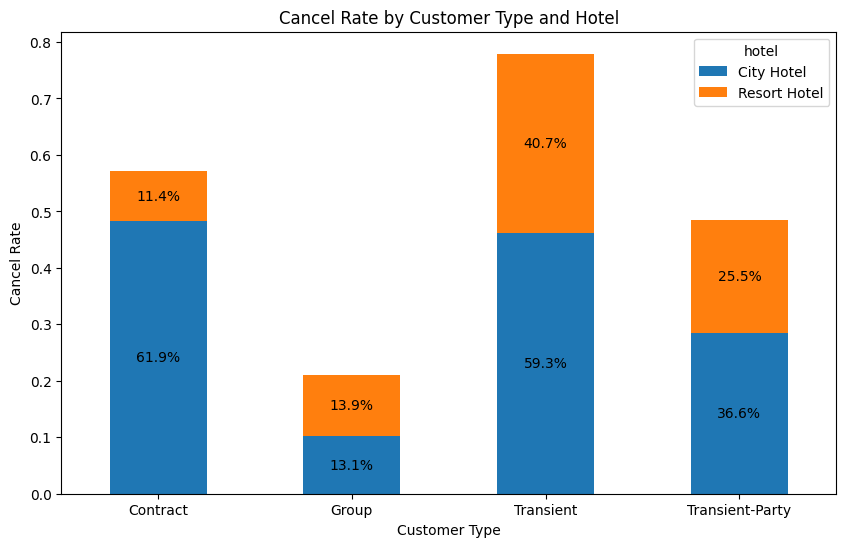

In [22]:
# Calculate cancel rate by customer type and hotel
cancel_rate_by_cat1 = main_df.groupby(['customer_type', 'hotel'])['is_canceled'].mean().reset_index()

# Create a pivot table for easier plotting
pivot_cancel_rate = cancel_rate_by_cat1.pivot(index='customer_type', columns='hotel', values='is_canceled')

# Plotting stacked bar chart
ax = pivot_cancel_rate.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#1f77b4', '#ff7f0e'])

# Set labels and title
ax.set_ylabel('Cancel Rate')
ax.set_xlabel('Customer Type')
ax.set_title('Cancel Rate by Customer Type and Hotel')
plt.xticks(rotation=0)

# Add percentage labels to each part of the stacked bars
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    x, y = p.get_xy()  # Get x and y position of the bar
    percentage = height / pivot_cancel_rate.sum(axis=1).max() * 100  # Calculate percentage
    ax.text(x + width / 2, y + height / 2, f'{percentage:.1f}%', ha='center', va='center')

# Show plot
plt.show()

As seen above, Contract Customers in City Hotel have the highest cancellation rate. Meanwhile, Transient Customers in Resort Hotel have the highest cancellation rate. This makes sense, as City Hotels might be more focused on attracting Contract Customers, who could have different booking behaviors. On the other hand, Resort Hotels may attract more Transient Customers, who are more likely to cancel their bookings, leading to higher cancellation rates in this segment.

## Where do cancellations occur most frequently—within a specific hotel type or channel?

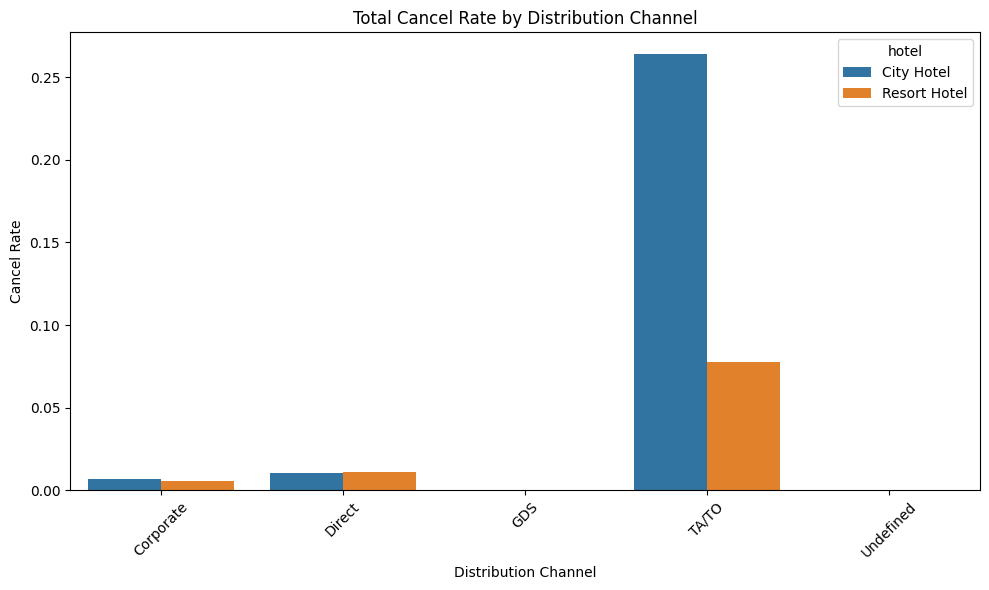

In [23]:
# Total booking in the entire dataset
total_booking = len(main_df)

# Function to calculate cancel rate per group: cancel / total booking for all channels
def cancel_rate_overall(x):
    return x.sum() / total_booking

# Calculate cancel rate per distribution_channel (and also hotel if needed)
cancel_rate_by_channel = main_df.groupby(['distribution_channel', 'hotel'])['is_canceled'].agg(cancel_rate_overall)

# Reset index to use in plotting
cancel_rate_df = cancel_rate_by_channel.reset_index(name='cancel_rate')

# Plot using matplotlib
plt.figure(figsize=(10, 6))

# Create a bar plot
sns.barplot(data=cancel_rate_df, x='distribution_channel', y='cancel_rate', hue='hotel')

# Set labels and title
plt.title('Total Cancel Rate by Distribution Channel')
plt.xlabel('Distribution Channel')
plt.ylabel('Cancel Rate')

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to prevent label clipping
plt.show()

On both types of hotels, TA/TO (Travel Agents / Tour Operators) is the distribution channel with the highest cancellation rate. This makes sense, as the ease of making reservations through TA/TO encourages guests to use this channel more frequently. However, when guests need to cancel their booking, they often go through the same channel (TA/TO). Consequently, this increases the cancellation rate for reservations made through TA/TO. Therefore, it is logical that TA/TO contributes significantly to the higher cancellation rate.

## How much does guest loyalty (i.e., repeated bookings) correlate with cancellation behavior?

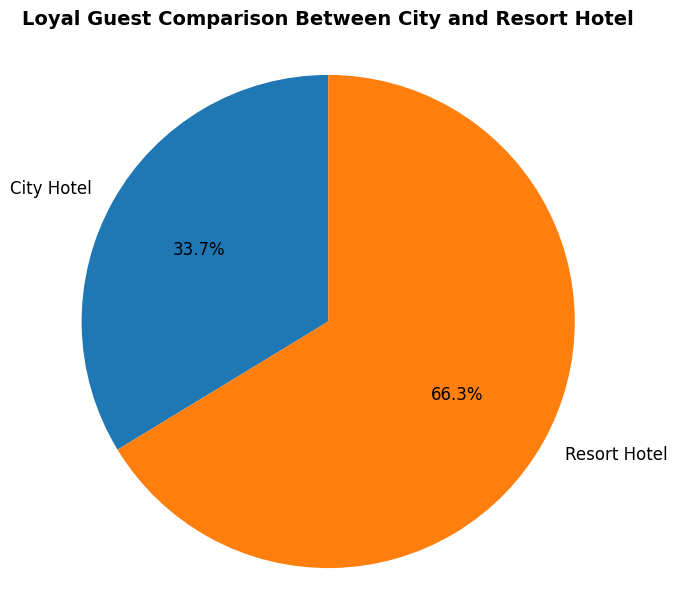

In [24]:
# Grouping by hotel and calculating the mean of 'is_repeated_guest' (loyal guest)
loyalty = main_df.groupby('hotel')['is_repeated_guest'].mean().reset_index()

# Pie chart: 'loyalty' values are the mean of repeated guests per hotel type
labels = loyalty['hotel']
sizes = loyalty['is_repeated_guest']

# Creating a pie chart
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 12})
plt.title('Loyal Guest Comparison Between City and Resort Hotel', fontsize=14, weight='bold', pad=20)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie chart
plt.show()

As seen in the pie chart, there are fewer loyal guests in City Hotel (33.7%) compared to Resort Hotel (66.3%). This could be related to the typical customer profile of each hotel. Customers in City Hotels are likely business travelers who visit the hotel for work purposes, resulting in fewer repeat stays. On the other hand, Resort Hotels tend to attract families or vacationers who return for holiday seasons, thus fostering a higher rate of loyalty among guests. This difference in customer behavior may explain the disparity in the loyalty rates between the two hotel types.

## How have cancellation trends evolved from 2015 to 2017?

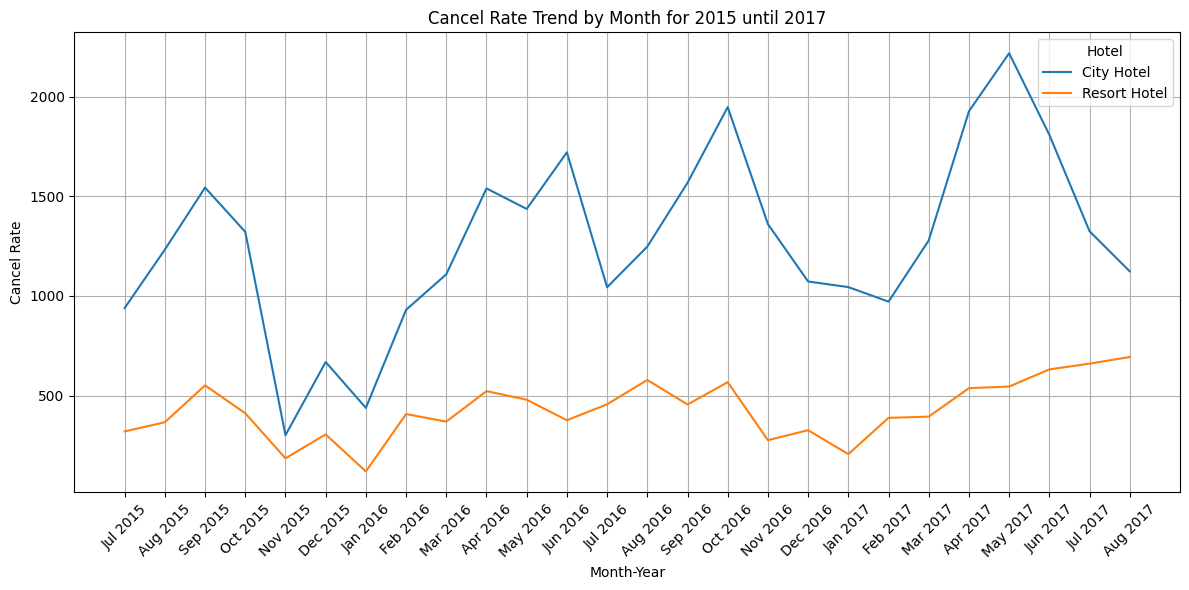

In [25]:
# Extract 'Month Year' from 'arrival_date'
main_df['Month Year'] = main_df['arrival_date'].dt.to_period('M')

# Calculate cancel rate per month for each hotel
cancel_trend_monthly = main_df.groupby(['hotel', 'Month Year'])['is_canceled'].sum().reset_index()

# Plotting the trend
plt.figure(figsize=(12, 6))

# Plot cancel rate for each hotel
for hotel in cancel_trend_monthly['hotel'].unique():
    data = cancel_trend_monthly[cancel_trend_monthly['hotel'] == hotel]
    plt.plot(data['Month Year'].dt.strftime('%b %Y'), data['is_canceled'], label=hotel)

# Formatting the plot
plt.title('Cancel Rate Trend by Month for 2015 until 2017')
plt.xlabel('Month-Year')
plt.ylabel('Cancel Rate')
plt.xticks(rotation=45)
plt.legend(title='Hotel')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

As seen above that the cancellation rate fluctuates over time. Specifically, there are noticeable peaks in cancellation rates at different times for each hotel type:

- City Hotel: The peak cancellation rates are observed in May-June and September-October.

- Resort Hotel: The peak cancellation rate is seen in August.

This pattern might suggest seasonal trends, where certain times of the year have higher cancellation rates due to factors like weather, travel preferences, or holiday periods. For City Hotels, the fluctuations around May-June and September-October might relate to business travel cycles or seasonal events, while Resort Hotels could be seeing higher cancellations in August due to summer vacations or shifts in travel plans.

# Conclusion

1. For Resort Hotel:
    - The cancellation rate is 28%.
    - Transient customer type and the TA/TO distribution channel has the highest cancellation rate
    - The number of cancellations tends to be high in August each year.


2. For City Hotel:
    - The cancellation rate is 42%.
    - Contract customer type and the TA/TO distribution channel has the highest cancellation rate.
    - The number of cancellations tends to be high in May–June and September–October.

3. The long period between booking and check-in time are affected to cancellation.

4. Loyal guests tend to not cancel their booking.

# Recommendation

1. Develop a loyalty program for repeat guests, offering benefits such as discounts/exclusive offers, early check-in, or free room upgrades. This could help reduce cancellations by encouraging loyal customers to return and secure bookings.
2. Evaluate partnerships with travel agencies (TA/TO) to identify opportunities for improvement in the booking and cancellation process.
3. Offer additional discounts or incentives for transient customers who opt for non-refundable rates to reduce cancellations.
4. Provide options for customers to change their booking dates (re-schedule) instead of canceling outright, which can help reduce cancellations.
5. Run targeted campaigns during peak cancellation periods (e.g., May-June and September-October) to encourage more bookings.
6. Increase flexibility for booking changes during peak cancellation periods, offering guests more options to re-scheduling their stay instead of canceling.